In [2]:
                                                # IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import scipy.stats as stats
from scipy.optimize import brentq
from scipy.optimize import curve_fit
import os
import ccxt
import datetime as dt
import seaborn as sns
import yfinance as yf

                                                    # CREATING THE RESULTS DIRECTORY FOR THE PROBLEMS SETS 
results_dir='RESULTS_WEEK_2'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)



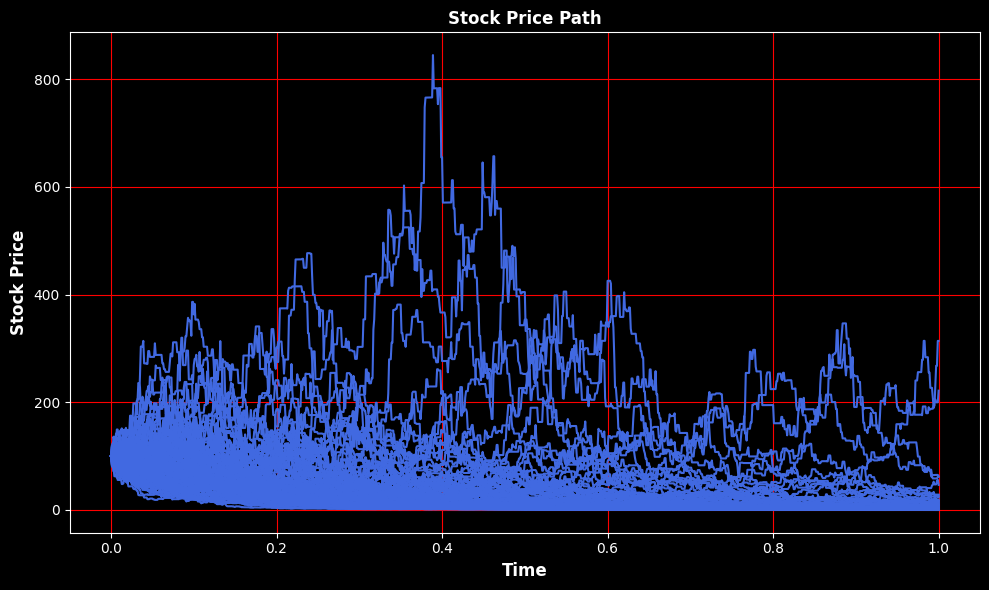

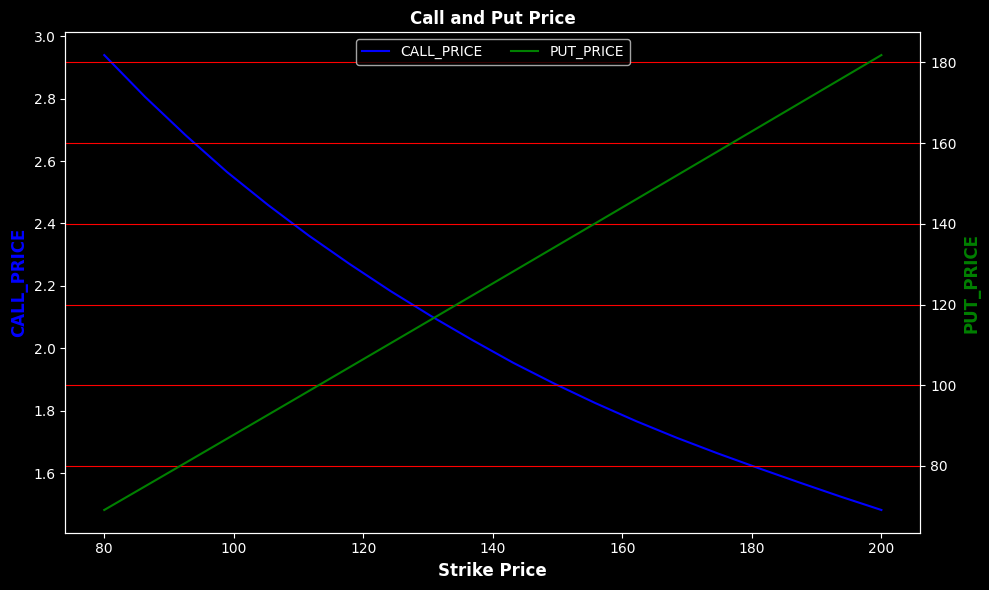

In [7]:
                                    # DAY 1 MERTON JUMP MODEL WITH POISSON JUMPS AND MONTE CARLO PRICING FOR OPTIONS
        
                                    
                                        # INITIALIZING THE IMPORTANT PARAMTERS 
S_0=100                                 # INITIAL STOCK PRICE
RISK_FREE_RATE=0.05                     # 5% RISK FREE T_BILL RATE
VOLATILITY_STOCK=0.20                   # VOLATILITY OF STOCK
STRIKES=np.linspace(80,200,20)          # STRIKE VALUES
DURATION=1                              # TIME TO Maturity
Nofpaths=10000                          # NUMBER OF PATHS
Nofsteps=1000                           # Number of time steps
LAMBDA=0.5                              # poisson jump intensity
JUMP_MEAN=-0.0108                       # JUMP MAGNITUDE MEAN
JUMP_VOLATILTITY=0.10                   # JUMP MAGNITUDE VOLAITILTY
PRICES=pd.DataFrame(index=STRIKES)      # STRIKE PRICE DATAFRAME
EPSILON=1e-4                            # LOWER BOUND SCALE FACTOR FOR THE STOCK PRICE FOR THE DIFFUSION MODEL
day_result='JUMP_DIFFUSION_MERTON_MODEL'# DAY 1 RESULTS DIRECTORY

''' MODEL CHARACTERISTICS
1) THE JUMP FOLLOWS THE POSSION INDICATOR PROCESS 
2) THE JUMP SIZE IS A RANDOM NORMAL  VARIABLE WITH A GIVEN MEAN AND VOLATILITY
3) THE JUMP SIZE IS NOT CORRELATED WITH THE STOCK PRICE MOVEMENTS
4) THE VOLATILITY AND THE JUMP PARAMTERS AND NON STOCHASTIC 
5) THE METHOD FOR PATH GENERATION WILL BE EULER DISCRETISATION
6) THE JUMP PARAMETERS ARE SET TO SIMULATE STOCK CRASH SCENARIOS
'''
                                            # CREATE THE RESULTS DIRECTORY CONCATENATED WITHE MAIN RESULTS DIRECTPRY
fold_path=os.path.join(results_dir,day_result)
if not os.path.exists(fold_path):
    os.makedirs(fold_path)

                                            # PATH GENERATION FUNCTION


def Path_Generation(INITIAL_STOCK,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON=1e-4):
    STOCK_PATHS=np.zeros((Nofpaths,Nofsteps+1))
    z=np.random.randn(Nofpaths,Nofsteps)
    STOCK_PATHS[:,0]=INITIAL_STOCK
    dt=DURATION/Nofsteps
    poisson=np.random.poisson(LAMBDA,size=(Nofpaths,Nofsteps))
    poisson=np.where(poisson>0,1,0)
    jump_mag=np.random.normal(JUMP_MEAN,JUMP_VOLATILTITY,size=(Nofpaths,Nofsteps))
    time=[i*dt for i in range(Nofsteps+1)]
    PARAMTERS={}
    for I in range(Nofsteps):
        z[:,I]=(z[:,I]-np.mean(z[:,I]))/(np.std(z[:,I]))
        STOCK_PATHS[:,I+1]=STOCK_PATHS[:,I] + STOCK_PATHS[:,I]*(RISK_FREE_RATE-LAMBDA*(np.mean(np.exp(jump_mag[:,I]))-1))*dt + VOLATILITY_STOCK*z[:,I]*np.sqrt(dt) + STOCK_PATHS[:,I]*(np.exp(jump_mag[:,I])-1)*poisson[:,I]
        STOCK_PATHS[:,I+1]=np.maximum(STOCK_PATHS[:,I+1],EPSILON*(-STOCK_PATHS[:,I+1])) 
        
    PARAMTERS['PATHS']=STOCK_PATHS
    PARAMTERS['TIME']=time
    PARAMTERS['POISSON_MATRIX']=poisson
    PARAMTERS['JUMP_MAGNITUDE_MATRIX']=jump_mag
    PARAMTERS['STOCK_MATURITY']=STOCK_PATHS[:,-1]
    return PARAMTERS

                                            #INITIALISING THE STOCK PATHS AND TIME STAMPS AND STORING THEM UN THE PARATERS VARIABLE TO AVOID LOOPING AND COMPUATATIONAL TIME 

parameters=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)



                                            # DEFINING THE MONTE CARLO PRICING FUNCTION
def monte_carlo_pricing(type,INITIAL_STOCK,STRIKE,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters):
     
     S_T=parameters['STOCK_MATURITY']
     type=type.lower()
     if type=='call':
         price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(S_T-STRIKE,0))
     elif type=='put':
        price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(STRIKE-S_T,0))
     return price
    
PRICES['CALL_PRICE']=[monte_carlo_pricing('call',S_0,strike,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters) for strike in STRIKES]
PRICES['PUT_PRICE']=[monte_carlo_pricing('put',S_0,strike,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters) for strike in STRIKES]
PRICES.index.name='STRIKE PRICE'
FILE_PATH=os.path.join(fold_path,'MERTON_JUMP_MODEL_PRICES.csv')
PRICES.to_csv(FILE_PATH)



                                                # PLOTTING THE STOCK PATHS AND THE CALL AND PUT PRICES

                                               
                                               
                                               
                                                # plotting the simulated stock price paths  first 100 sample paths
PARAMETERS=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths)
PATHS=PARAMETERS['PATHS']
TIME=PARAMETERS['TIME']

fig,ax=plt.subplots(figsize=(10,6))
plt.style.use('dark_background')

for i in range(100):
    ax.plot(TIME,PATHS[i,:],color='royalblue')   
ax.set_xlabel('Time',fontdict={'weight':'bold','size':12})
ax.set_ylabel('Stock Price',fontdict={'weight':'bold','size':12})
ax.set_title('Stock Price Path',fontdict={'weight':'bold','size':12})

plt.grid(True,color='r',linestyle='-')
fig_path=os.path.join(fold_path,'MERTON_JUMP_MODEL_STOCK_PATHS.png')
plt.tight_layout()
plt.savefig(fig_path,bbox_inches='tight',dpi=300)
plt.show()

                                                
                                                
                                                
                                                # plotting the call and put prices
fig,ax=plt.subplots(figsize=(10,6))
plt.style.use('dark_background')

ax.plot(STRIKES,PRICES['CALL_PRICE'],color='blue',label='CALL_PRICE')
ax.set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax.set_ylabel('CALL_PRICE',fontdict={'weight':'bold','size':12},color='blue')


ax1=ax.twinx()
ax1.plot(STRIKES,PRICES['PUT_PRICE'],color='GREEN',label='PUT_PRICE')
ax1.set_ylabel('PUT_PRICE',fontdict={'weight':'bold','size':12},color='green')

lines1,labels1= ax.get_legend_handles_labels()
lines2,labels2= ax1.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='upper center',frameon=True,ncol=2,fontsize=10)


plt.title('Call and Put Price',fontdict={'weight':'bold','size':12})
plt.grid(True,color='r',linestyle='-')


fig_path=os.path.join(fold_path,'MERTON_JUMP_MODEL_CALL_PUT_PRICES.png')

plt.tight_layout()
plt.savefig(fig_path,bbox_inches='tight',dpi=300)
plt.show()
                                                                        



C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_16832\640616153.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


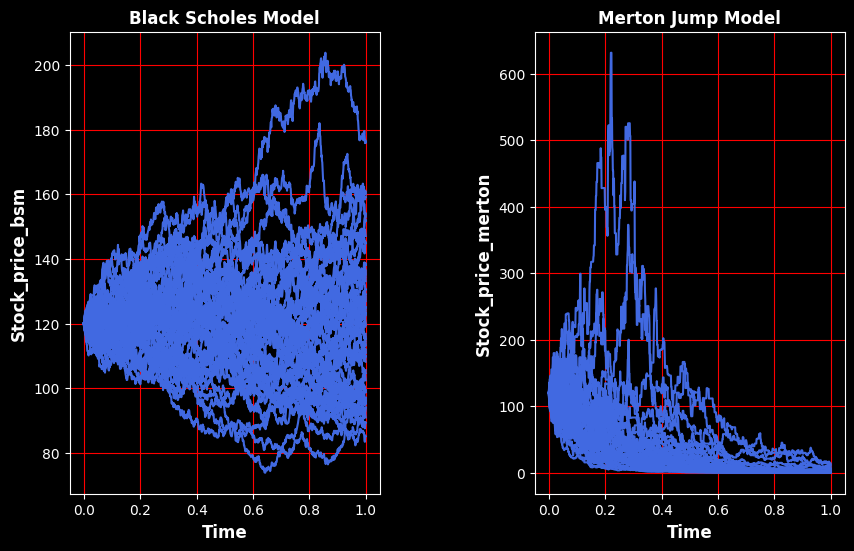

C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_16832\640616153.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


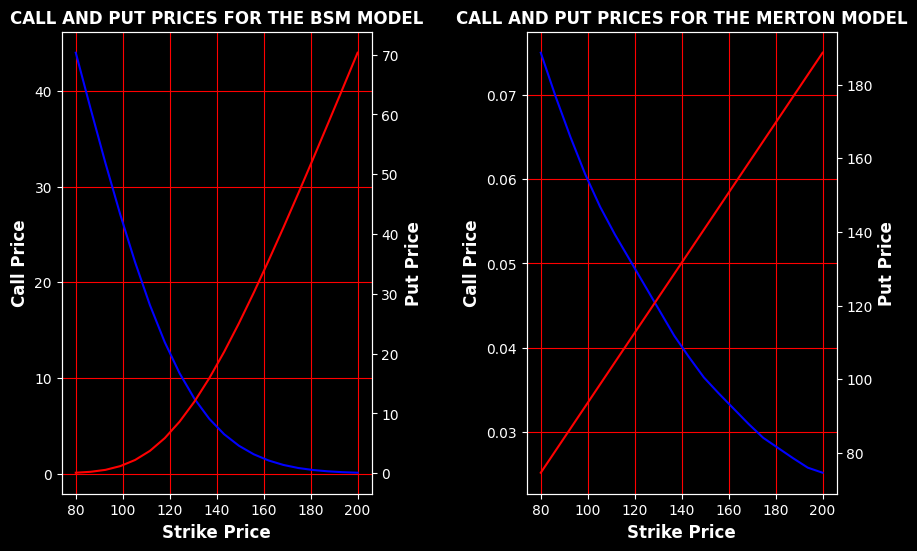

C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_16832\640616153.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


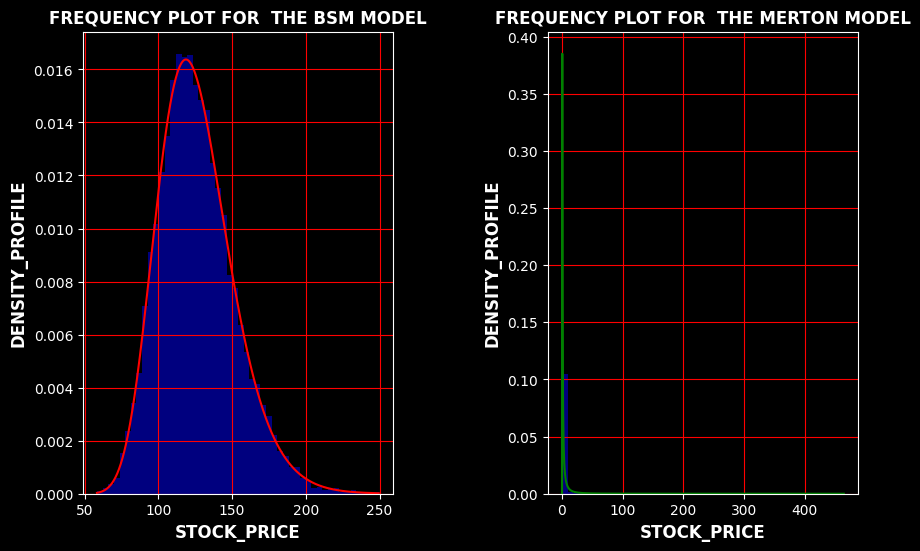

In [4]:
                    # DAY 3 PROBLEM COMPARITIVE ANALYSIS OF MERTON JUMP MODEL AND BLACK SCHOLES MODEL
                    
                                
                                
                                # CREATING THE RESULTS DIRECTORY FOR THE PROBLEMS SETS

DAY_RESULTS_DIR = 'COMPARITIVE_ANALYSIS_MERTON_JUMP_MODEL_AND_BLACK_SCHOLES_MODEL'
fold_path=os.path.join(results_dir,DAY_RESULTS_DIR)
if not os.path.exists(fold_path):
    os.makedirs(fold_path)


'''MODEL CHARACTERISTICS:

1) THE JUMP FOLLOWS THE POSSION INDICATOR PROCESS
2) THE JUMP SIZE IS A RANDOM NORMAL  VARIABLE WITH A GIVEN MEAN AND VOLATILITY
3) THE BLACK SHCOLES MODEL IS PRICED USING THE DIFFUSION MODEL MONTE CARLO PRICING
4) THE JUMP SIZE IS NOT CORRELATED WITH THE STOCK PRICE MOVEMENTS
5) COMPARATIVE ANALYSIS OF THE JUMP MODEL AND THE BLACK SCHOLES MODEL IS PERFROMED FOR A RANGE OF STRIKES
6) THE VOLATILITY AND THE JUMP PARAMTERS ARE  NON STOCHASTIC

'''
                                    # DEFINING THE INPUT PARAMTERS FOR THE COMPARATIVE ANAYLIS MODEL


S_0=120                                 # INITIAL STOCK PRICE
RISK_FREE_RATE=0.05                     # 5% RISK FREE T_BILL RATE
VOLATILITY_STOCK=0.20                   # VOLATILITY OF STOCK
STRIKES=np.linspace(80,200,20)          # STRIKE VALUES
DURATION=1                              # TIME TO Maturity
Nofpaths=10000                          # NUMBER OF PATHS
Nofsteps=1000                           # Number of time steps
LAMBDA=0.5                             # poisson jump intensity
JUMP_MEAN=-0.0148                       # JUMP MAGNITUDE MEAN
JUMP_VOLATILTITY=0.0850                   # JUMP MAGNITUDE VOLAITILTY
EPSILON=1e-4                            # LOWER BOUND SCALE FACTOR  FOR THE STOCK IN JUMP MODEL
QUANTITATIVE_INFERENCE=pd.DataFrame(
    index=STRIKES)                      # INITIALISING THE RESULTS DATAFRAME FOR THE QUANTITATIVE INFERENCE                                  
                                
                                
                                
                                
                                
                                # DEFINING THE PATH GENERATION FUNCTION FOR THE BLACK SCHOLES MODEL
def Path_Generation_BS(INITIAL_STOCK,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths):
    STOCK_PATHS=np.zeros((Nofpaths,Nofsteps+1))
    z=np.random.randn(Nofpaths,Nofsteps)
    STOCK_PATHS[:,0]=INITIAL_STOCK
    dt=DURATION/Nofsteps
    time=[i*dt for i in range(Nofsteps+1)]
    parameters={}
    for I in range(Nofsteps):
        z[:,I]=(z[:,I]-np.mean(z[:,I]))/(np.std(z[:,I]))
        STOCK_PATHS[:,I+1]=STOCK_PATHS[:,I] + STOCK_PATHS[:,I]*(RISK_FREE_RATE)*dt + VOLATILITY_STOCK*z[:,I]*np.sqrt(dt)*STOCK_PATHS[:,I]
    parameters['PATHS']=STOCK_PATHS
    parameters['TIME']=time
    parameters['STOCK_MATURITY']=STOCK_PATHS[:,-1]
       
        
    return parameters

                                                # INIITILIZING THE STOCK PATHS AND TIME STAMPS FOR BLACK SCHOLES MODEL BY CALLING THE ABOVE FUCNTION

parameters_bs=Path_Generation_BS(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths)

                                                # INITIALISING THE STOCK PATHS AND TIME STAMPS FOR JUMP MODEL BY CALLING THE FUCNTION FROM THE PENULTIMATE CELL
parameters_merton=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)

                                
                                                # DEFINING THE MONTE CARLO PRICING FUCNTION FOR THE TWO MODELS AND OPTIONS
def monte_carlo_pricing(model,type,strike,RISK_FREE_RATE,DURATION,parameters_bsm,parameters_merton):
    model=model.lower()
    type=type.lower()
    S_T_bsm=parameters_bsm['STOCK_MATURITY']
    S_T_merton=parameters_merton['STOCK_MATURITY']
    if model=='bsm':
        if type=='call':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(S_T_bsm-strike,0))
        elif type=='put':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(strike-S_T_bsm,0))
    elif model=='merton':
        if type=='call':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(S_T_merton-strike,0))
        elif type=='put':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(strike-S_T_merton,0))

    return price


                                                # PRICING THE CALL AND PUT OPTIONS FOR THE TWO MODELS AND STORING THEM IN THE QUANTITATIVE INFERENCE DATAFRAME 

QUANTITATIVE_INFERENCE['CALL_PRICE_BSM']=[monte_carlo_pricing('bsm','call',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE['PUT_PRICE_BSM']=[monte_carlo_pricing('bsm','put',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE['CALL_PRICE_MERTON']=[monte_carlo_pricing('merton','call',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE['PUT_PRICE_MERTON']=[monte_carlo_pricing('merton','put',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE.index.name='STRIKE PRICE'
QUANTITATIVE_INFERENCE['BSM_KURTOSIS']=[stats.kurtosis(Path_Generation_BS(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths)['STOCK_MATURITY']) for I in range(len(STRIKES))]
QUANTITATIVE_INFERENCE['BSM_SKEWNESS']=[stats.skew(Path_Generation_BS(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths)['STOCK_MATURITY']) for I in range(len(STRIKES))]
QUANTITATIVE_INFERENCE['MERTON_KURTOSIS']=[stats.kurtosis(Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)['STOCK_MATURITY']) for I in range(len(STRIKES))]
QUANTITATIVE_INFERENCE['MERTON_SKEWNESS']=[stats.skew(Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)['STOCK_MATURITY']) for I in range(len(STRIKES))]
file_path=os.path.join(fold_path,'QUANTITATIVE_INFERENCE.csv')
QUANTITATIVE_INFERENCE.to_csv(file_path)                                      
                                                
                                                
                                                # PLOTTING THE DIFFSUSION  AND MERTON JUMP MODEL STOCK PATHS 

fig,ax=plt.subplots(1,2,figsize=(10,6),gridspec_kw={'hspace':0.3,'wspace':0.5})
plt.style.use('dark_background')
paths_bsm=parameters_bs['PATHS']
paths_merton=parameters_merton['PATHS']
time=parameters_bs['TIME']

for i in range(50):
    ax[0].plot(time,paths_bsm[i,:],color='royalblue')
    ax[1].plot(time,paths_merton[i,:],color='royalblue')

ax[0].set_xlabel('Time',fontdict={'weight':'bold','size':12})
ax[0].set_ylabel('Stock_price_bsm',fontdict={'weight':'bold','size':12})
ax[1].set_xlabel('Time',fontdict={'weight':'bold','size':12})
ax[1].set_ylabel('Stock_price_merton',fontdict={'weight':'bold','size':12})
ax[0].set_title('Black Scholes Model',fontdict={'weight':'bold','size':12})
ax[1].set_title('Merton Jump Model',fontdict={'weight':'bold','size':12})
ax[0].grid(True,color='r',linestyle='-')
ax[1].grid(True,color='r',linestyle='-')
FILE_PATH=os.path.join(fold_path,'DIFFUSION_AND_JUMP_MODEL_STOCK_PATHS.png')
plt.tight_layout()
plt.savefig(FILE_PATH,bbox_inches='tight',dpi=300)
plt.show()

                                    
                                        
                                    
                                    # PLOTTING THE CALL AND PUT PRICES FOR THE TWO MODELS

fig,ax=plt.subplots(1,2,figsize=(10,6),gridspec_kw={'hspace':0.3,'wspace':0.5})
plt.style.use('dark_background')

ax[0].plot(STRIKES,QUANTITATIVE_INFERENCE['CALL_PRICE_BSM'],color='blue',label='CALL_PRICE_BSM')
ax1=ax[0].twinx()
ax1.plot(STRIKES,QUANTITATIVE_INFERENCE['PUT_PRICE_BSM'],color='red',label='PUT_PRICE_BSM')
ax[0].set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax[0].set_ylabel('Call Price',fontdict={'weight':'bold','size':12})
ax1.set_ylabel('Put Price',fontdict={'weight':'bold','size':12})
ax[0].set_title('CALL AND PUT PRICES FOR THE BSM MODEL',fontdict={'weight':'bold','size':12})
ax[0].grid(True,color='r',linestyle='-')


ax[1].plot(STRIKES,QUANTITATIVE_INFERENCE['CALL_PRICE_MERTON'],color='blue',label='CALL_PRICE_MERTON')
ax2=ax[1].twinx()
ax2.plot(STRIKES,QUANTITATIVE_INFERENCE['PUT_PRICE_MERTON'],color='red',label='PUT_PRICE_MERTON')
ax[1].set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax[1].set_ylabel('Call Price',fontdict={'weight':'bold','size':12})
ax2.set_ylabel('Put Price',fontdict={'weight':'bold','size':12})
ax[1].set_title('CALL AND PUT PRICES FOR THE MERTON MODEL',fontdict={'weight':'bold','size':12})
ax[1].grid(True,color='r',linestyle='-')    

FILE_PATH=os.path.join(fold_path,'CALL_AND_PUT_PRICES_FOR_THE_MODELS.png')
plt.tight_layout()
plt.savefig(FILE_PATH,bbox_inches='tight',dpi=300)
plt.show()

                    
                    
                    
                    # PLOTTING THE STOCK AT MATURIRY FREQUENCY PLOTS WITH ESTIMATED DENSITY FUCNTION FROM THE GIVEN DATA FOR THE TWO MODELS 
fig,ax=plt.subplots(1,2,figsize=(10,6),gridspec_kw={'hspace':0.3,'wspace':0.5})
plt.style.use('dark_background')

ST_BSM=parameters_bs['STOCK_MATURITY']
ST_MERTON=parameters_merton['STOCK_MATURITY']
shape_bsm,loc_bsm,scale_bsm=stats.lognorm.fit(ST_BSM,floc=0)
shape_merton,loc_merton,scale_merton=stats.lognorm.fit(ST_MERTON,floc=0)
x_bsm=np.linspace(ST_BSM.min(),ST_BSM.max(),1000)
x_merton=np.linspace(ST_MERTON.min(),ST_MERTON.max(),1000)
y_bsm=stats.lognorm.pdf(x_bsm,shape_bsm,loc_bsm,scale_bsm)
y_merton=stats.lognorm.pdf(x_merton,shape_merton,loc_merton,scale_merton)

ax[0].hist(ST_BSM,bins=50,density=True,color='blue',alpha=0.5)
ax[0].plot(x_bsm,y_bsm,color='red')
ax[0].set_xlabel('STOCK_PRICE',fontdict={'weight':'bold','size':12})
ax[0].set_ylabel('DENSITY_PROFILE',fontdict={'weight':'bold','size':12})
ax[0].set_title('FREQUENCY PLOT FOR  THE BSM MODEL',fontdict={'weight':'bold','size':12})
ax[0].grid(True,color='r',linestyle='-')

ax[1].hist(ST_MERTON,bins=50,density=True,color='blue',alpha=0.5)
ax[1].plot(x_merton,y_merton,color='green')
ax[1].set_xlabel('STOCK_PRICE',fontdict={'weight':'bold','size':12})
ax[1].set_ylabel('DENSITY_PROFILE',fontdict={'weight':'bold','size':12})
ax[1].set_title('FREQUENCY PLOT FOR  THE MERTON MODEL',fontdict={'weight':'bold','size':12})
ax[1].grid(True,color='r',linestyle='-')

FILE_PATH=os.path.join(fold_path,'FREQUENCY_PLOT_FOR_THE_MODELS.png')
plt.tight_layout()
plt.savefig(FILE_PATH,bbox_inches='tight',dpi=300)
plt.show()





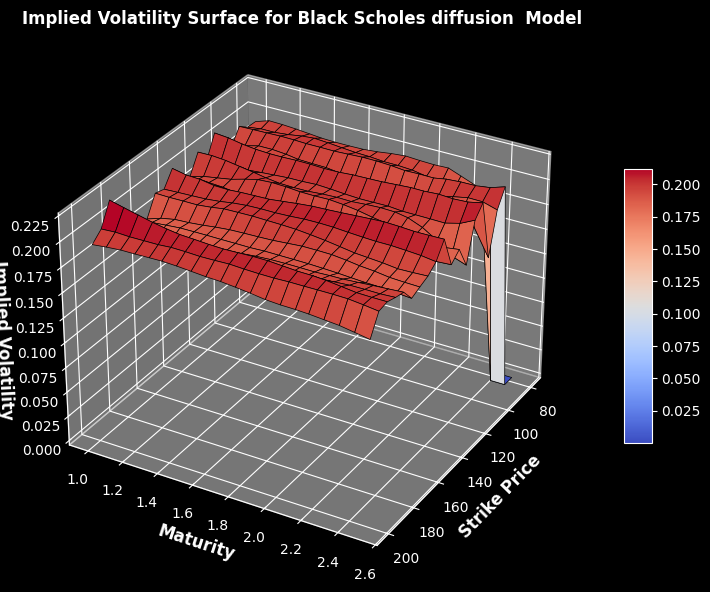

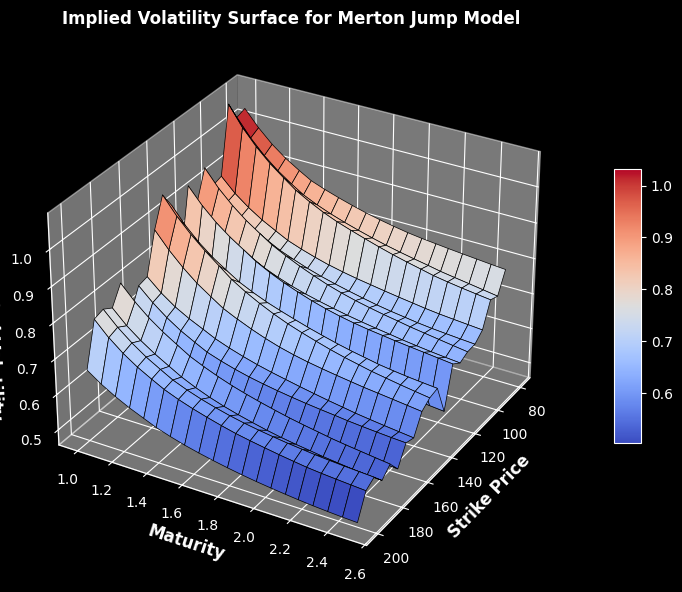

In [5]:
                # DAY 4 VOLAITILITY SURFACE PLOTTING FOR THE MERTON JUMP MODEL AND BLACK SCHOLES MODEL
                
                    # CREATING THE RESULTS DIRECTORY FOR THE DAY 4 PROBLEMS SETS

day_results_dir='VOLATILITY_SURFACE_MERTON_BLACK_SCHOLES'
fold_path=os.path.join(results_dir,day_results_dir)
if not os.path.exists(fold_path):
    os.makedirs(fold_path)



''' MODEL CHARACTERISTICS:
1) THE JUMP FOLLOWS THE POSSION INDICATOR PROCESS
2) THE COMPARATIVE MODEL USED IS THE NORMAL DIFFUSION MODEL
3) THR VOLAITLITY SURFACE GENERATION IS DONE USING THE MESH GRIF OF STRIKES AND DURATION
4) THE PRICE USED FOR IMPLIED VOLALTITLYT CALCULATION ARE GENRATED USING THE MONTE CARLO PRICING METHOD WITH A FIXED INNITIAL TRUE VOLILTITY
5) THE IMPLIED VOLATILITY IS CALCULATED USING THE BLACK SCHOLES FORMULA FOR BOTH MERTON AND DIFFFUISON PROCESS BY USEING THE BRENTQUADRIATIC METHOD

'''                        
                        
                                # DEFINING THE INPUT PARAMTERS FOR THE VOLATILITY SURFACE MODEL

S_0=100                                # INITIAL STOCK PRICE
RISK_FREE_RATE=0.05                    # 5% RISK FREE T_BILL RATE                         
TRUE_VOLATILITY_STOCK=0.20             # TRUE VOLATILITY OF STOCK
MU_JUMP=-0.00108                       # JUMP MAGNITUDE MEAN
LAMBDA=0.5                             # poisson jump intensity
JUMP_VOLATILTITY=0.10                  # JUMP MAGNITUDE VOLAITILTY
EPSILON=1e-4                           # LOWER BOUND SCALE FACTOR  FOR THE STOCK IN JUMP MODEL
STRIKES=np.linspace(80,200,20).round(2)         # STRIKE VALUES
DURATION=np.linspace(1,2.5,20).round(2)        # TIME TO Maturity IN YEARS 
Nofpaths=1000                          # NUMBER OF PATHS
Nofsteps=100                           # Number of time steps                   


CALL_PRICES_MATRIX_MERTON=pd.DataFrame(index=STRIKES,columns=DURATION)              # CALL PRICES DATAFRAME FOR THE MERTON MODEL
CALL_PRICES_MATRIX_BS=pd.DataFrame(index=STRIKES,columns=DURATION)                  # CALL PRICES DATAFRAME FOR THE BLACK SCHOLES MODEL
CALL_IMPLIED_VOLATILITY_MATRIX_MERTON=pd.DataFrame(index=STRIKES,columns=DURATION)  #  IMPLIED VOLATILITY DATAFRAME FOR THE MERTON MODEL CALCULTED USING THE CALL PRICES
CALL_IMPLIED_VOLATILITY_MATRIX_BS=pd.DataFrame(index=STRIKES,columns=DURATION)      # IMPLIED VOLATILITY DATAFRAME FOR THE BLACK SCHOLES MODEL CALCULTED USING THE CALL PRICES

CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.index.name='STRIKE PRICE'
CALL_IMPLIED_VOLATILITY_MATRIX_BS.index.name='STRIKE PRICE'
CALL_PRICES_MATRIX_MERTON.index.name='STRIKE PRICE'
CALL_PRICES_MATRIX_BS.index.name='STRIKE PRICE'
CALL_PRICES_MATRIX_MERTON.columns.name='DURATION'
CALL_PRICES_MATRIX_BS.columns.name='DURATION'
CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.columns.name='DURATION'
CALL_IMPLIED_VOLATILITY_MATRIX_BS.columns.name='DURATION'





                                                # DEFINING THE IMPLIED VOLATILITY FUNCTION FOR THE BLACK SCHOLES MODEL AND MERTON JUMP MODEL
                   
                   
                                            
                                            
                                            
                                            # CALCUTING THE PRICES AND SOTRING THEM IN THE PRICE MATRIXES USING THE PATH GENERATION FUNCTION AND MONTE CARLO PRICING FUNCTION FROMT HE FORER AND LATTER CODES

for i in DURATION:
    parameters_merton=Path_Generation(S_0,RISK_FREE_RATE,TRUE_VOLATILITY_STOCK,i,LAMBDA,MU_JUMP,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)
    parameters_bs=Path_Generation_BS(S_0,RISK_FREE_RATE,TRUE_VOLATILITY_STOCK,i,Nofsteps,Nofpaths)
    CALL_PRICES_MATRIX_BS[i]=[monte_carlo_pricing('bsm','call',strike,RISK_FREE_RATE,i,parameters_bs,parameters_merton) for strike in STRIKES]
    CALL_PRICES_MATRIX_MERTON[i]=[monte_carlo_pricing('merton','call',strike,RISK_FREE_RATE,i,parameters_bs,parameters_merton) for strike in STRIKES]
    


CALL_PRICES_MATRIX_BS.dropna(axis=1,how='all',inplace=True)
CALL_PRICES_MATRIX_MERTON.dropna(axis=1,how='all',inplace=True)


                                    
                                    
                                    # DEFININNG THE BLACK SCHOLES PRICNG FUCNTION TO CALCULAYTE THE IMPLIED VOLAILTITY OF THE PRICES BY USING INVERSION METHOD ON THE GIVEN FUNCTION

def BSM(S0,K,T,r,sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call_price = S0*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
    return call_price

                            
                            
                            # DEFINING THE IMPLIED VOLATILITY FUNCTION FOR THE BLACK SCHOLES MODEL BY USING THE BRENTQUADRIATIC METHOD 
def implied_volatility_bsm(S0,K,T,r,C_implied,tol=1e-6):
    def objective_function(sigma):
        return BSM(S0,K,T,r,sigma) - C_implied
    
    try:
        implied_vol=brentq(objective_function, 1e-6, 10, xtol=tol)       
        return implied_vol
    except ValueError:
        return np.nan                    
                                    
                                    
                                    
                                    # CALCULATING THE IMPLIED VOLATILITY FOR THE BLACK SCHOLES MODEL AND THE MERTON MODEL BY USING THE BRENTQUADRIATIC METHOD USING RH ABOVE BSM FUCNTION AS FUCNTIONA INPUT
for i in DURATION:
    for j in STRIKES:
        CALL_IMPLIED_VOLATILITY_MATRIX_BS.loc[j,i]=implied_volatility_bsm(S_0,j,i,RISK_FREE_RATE,CALL_PRICES_MATRIX_BS.loc[j,i])
        CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.loc[j,i]=implied_volatility_bsm(S_0,j,i,RISK_FREE_RATE,CALL_PRICES_MATRIX_MERTON.loc[j,i])
CALL_IMPLIED_VOLATILITY_MATRIX_BS.dropna(axis=1,how='all',inplace=True)
CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.dropna(axis=1,how='all',inplace=True)


file_path=os.path.join(fold_path,'CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.csv')
file_path1=os.path.join(fold_path,'CALL_IMPLIED_VOLATILITY_MATRIX_BS.csv') 
CALL_IMPLIED_VOLATILITY_MATRIX_BS.to_csv(file_path1)
CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.to_csv(file_path)


                                    # PLOTTING THE IMPLIED VOLATILITY SURFACE FOR THE MERTON JUMP MODEL AND BLACK SCHOLES MODEL

                            
                            
                            # PLOTTING THE IMPLIED VOLATILITY SURFACE FOR THE BLACK SCHOLES DIFFUSION MODEL

strikes=CALL_IMPLIED_VOLATILITY_MATRIX_BS.index.values
maturity=CALL_IMPLIED_VOLATILITY_MATRIX_BS.columns.values
X,Y=np.meshgrid(strikes,maturity)
Z=CALL_IMPLIED_VOLATILITY_MATRIX_BS.values
Z=np.nan_to_num(Z,nan=np.mean(Z))


fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111,projection='3d')

surf=ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,edgecolor='k',linewidth=0.5,antialiased=True)
ax.set_title('Implied Volatility Surface for Black Scholes diffusion  Model',fontdict={'weight':'bold','size':12})
ax.set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax.set_ylabel('Maturity',fontdict={'weight':'bold','size':12})
ax.set_zlabel('Implied Volatility',fontdict={'weight':'bold','size':12})
ax.grid(True,color='r',linestyle='-')
ax.view_init(30,30)
fig.colorbar(surf,shrink=0.5,aspect=10)
file_path=os.path.join(fold_path,'IMPLIED_VOLATILITY_SURFACE_BS.png')
plt.tight_layout()
plt.savefig(file_path,bbox_inches='tight',dpi=300)
plt.show()
                  
                  
                  
                         
                         # PLOTTING THE IMPLIED VOLATILITY SURFACE FOR THE MERTON JUMP MODEL                  

strikes=CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.index.values
maturity=CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.columns.values
X,Y=np.meshgrid(strikes,maturity)
Z=CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.values
Z=np.nan_to_num(Z,nan=np.mean(Z))

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111,projection='3d')

surf=ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,edgecolor='k',linewidth=0.5,antialiased=True)
ax.set_title('Implied Volatility Surface for Merton Jump Model',fontdict={'weight':'bold','size':12})
ax.set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax.set_ylabel('Maturity',fontdict={'weight':'bold','size':12})
ax.set_zlabel('Implied Volatility',fontdict={'weight':'bold','size':12})
ax.grid(True,color='r',linestyle='-')
ax.view_init(30,30)
fig.colorbar(surf,shrink=0.5,aspect=10)
file_path=os.path.join(fold_path,'IMPLIED_VOLATILITY_SURFACE_MERTON.png')
plt.tight_layout()
plt.savefig(file_path,bbox_inches='tight',dpi=300)
plt.show()


    
                                                                      
                              
                                    







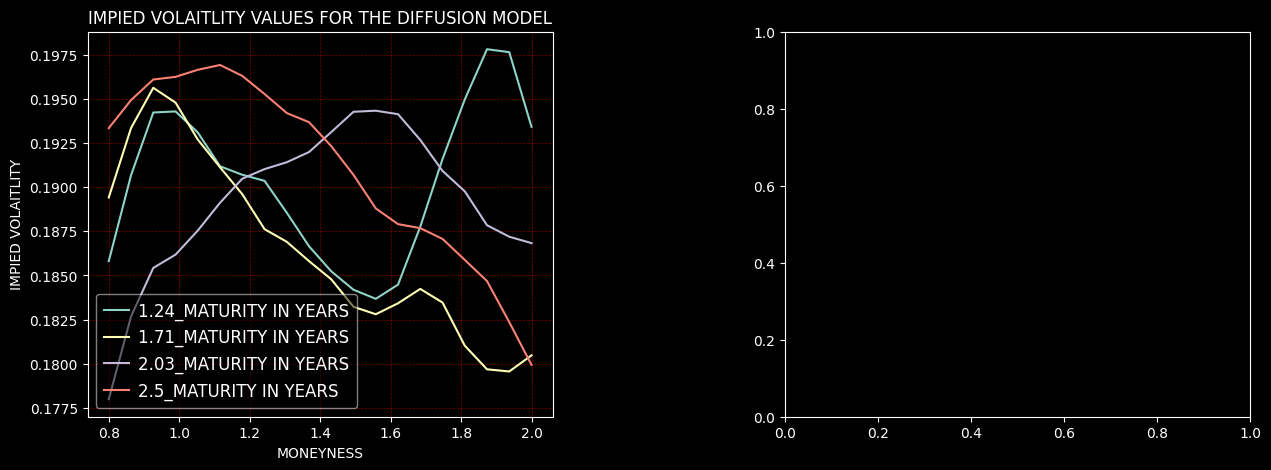

In [49]:
                # DAY 5 PLOTTING THE IMPLIED VOLATILOTY WITH RESPECT TO MONEYNESS FOR DIFFERENT MATURIRTUES TO OBSERVE THE SMILE AND SKEWNESS WITH IMPLIED VOLAILTITY CURVE FIT
                
                

day_results_dir='VOLATILITY_SMILE_ANALYSIS'
fold_path=os.path.join(results_dir,day_results_dir)
if not os.path.exists(fold_path):
    os.makedirs(fold_path)

''' 
    MODEL CHARACTERISTICS:

1) THE JUMP IS UNCOREELATED WITH THE STOCHASTIC VOLATILITY
2) THE IMPLIED VOLAILTITY IS CACLUETED USING THE BSM MODEL AND THE ERTON JUMP MODEL 
3) THE VALUES OF IMPLIED VOLAILTITY ARE OBTAINED BY INVERSION METHOD BRENTQUADRATIC METHOD
4) PLOTS FOR IMPLIED VOLATILITY ARE SHOWN WITH RESPECT TO MONEYNESS

''' 
                                                    # DEFINING THE MODEL PARAMTERS
                                                    
                

S_0=100                                         # INITIAL STOCK PRICE
RISK_FREE_RATE=0.05                             # 5% RISK FREE T_BILL RATE                         
TRUE_VOLATILITY_STOCK=0.20                      # TRUE VOLATILITY OF STOCK
MU_JUMP=-0.00108                                # JUMP MAGNITUDE MEAN
LAMBDA=0.5                                      # poisson jump intensity
JUMP_VOLATILTITY=0.10                           # JUMP MAGNITUDE VOLAITILTY
EPSILON=1e-4                                    # LOWER BOUND SCALE FACTOR  FOR THE STOCK IN JUMP MODEL
STRIKES=np.linspace(80,200,20).round(2)         # STRIKE VALUES
DURATION=np.linspace(1,2.5,20).round(2)         # TIME TO Maturity IN YEARS 
Nofpaths=1000                                   # NUMBER OF PATHS
Nofsteps=100                                    # Number of time steps                                                                       
MONEYNESS=STRIKES/S_0                           # MONEYNESS VALUES
SELECTED_DURATION=[1.24,1.71,2.03,2.50]         # SELECTED DURATION FOR PLOTTING THE IMPLIED VOLAITLITY CURVE AND CURVE FITIING                                           
                                                    
IMPLIED_VOLAITLITY_BSM=pd.DataFrame(index=MONEYNESS)        # CREATING THE IMPLIED VOLAILTITY DATA FRAME FOR DISFFUSIO MODEL 
IMPLIED_VOLAITLITY_MERTON=pd.DataFrame(index=MONEYNESS)     # CREATING THE IMPLIED VOLAILTITY DATA FRAME FOR MERTON MODEL
IMPLIED_VOLATILITY_FIT_BSM=pd.DataFrame(index=MONEYNESS)    # CREATING THE IMPLIED VOLAILTITY DATA FRAME FOR FITTING BSM MODEL
IMPLIED_VOLATILITY_FIT_MERTON=pd.DataFrame(index=MONEYNESS) # CREATING THE IMPLIED VOLAITLOTY DATA FRAME FOR FITTING THE JUMP MODEL

IMPLIED_VOLAITLITY_BSM.index.name='MONEYNESS'
IMPLIED_VOLAITLITY_MERTON.index.name='MONYENESS'
IMPLIED_VOLAITLITY_MERTON.columns.name='DURATION'
IMPLIED_VOLAITLITY_BSM.columns.name='DURATION'

IMPLIED_VOLATILITY_FIT_BSM.index.name='MONEYNESS'
IMPLIED_VOLATILITY_FIT_BSM.columns.name='DURATION'
IMPLIED_VOLATILITY_FIT_MERTON.index.name='MONEYNESS'
IMPLIED_VOLATILITY_FIT_MERTON.columns.name='DURATION'

                        # CREATING PSEUDO DATA FRAME FOR DATA COPYING WIOHTOUT ALTERING THR ORIGINAL DATA FRAME

pseudo_bs=CALL_IMPLIED_VOLATILITY_MATRIX_BS.copy()
pseudo_bs.set_index(MONEYNESS, inplace=True)
pseudo_merton=CALL_IMPLIED_VOLATILITY_MATRIX_MERTON.copy()
pseudo_merton.set_index(MONEYNESS, inplace=True)
                                       
for t in SELECTED_DURATION:
    IMPLIED_VOLAITLITY_BSM[t]=pseudo_bs[t]
    IMPLIED_VOLAITLITY_MERTON[t]=pseudo_merton[t]

                        # DEFINING THE CURVE FIT PARAMTERS AND FUNCTION TO OBRTAIN THE CURVE FIT VOLAILTITY VALUES 

def sigma_fit(x, a, b, c):
    return a+b*(x-1)**2+c*(x-1)

for T in SELECTED_DURATION:
    y_BSM=IMPLIED_VOLAITLITY_BSM[T].values
    y_merton=IMPLIED_VOLAITLITY_MERTON[T].values
    try:   
        popt_bsm,_=curve_fit(sigma_fit, MONEYNESS, y_BSM,maxfev=10000)
        popt_merton,_=curve_fit(sigma_fit, MONEYNESS, y_merton,maxfev=10000)
        IMPLIED_VOLATILITY_FIT_BSM[T]=sigma_fit(MONEYNESS, *popt_bsm)
        IMPLIED_VOLATILITY_FIT_MERTON[T]=sigma_fit(MONEYNESS, *popt_merton)
    except:
        IMPLIED_VOLATILITY_FIT_BSM[T]=np.nan
        IMPLIED_VOLATILITY_FIT_MERTON[T]=np.nan

                                
                                # PLOTTING THE IMPLIED VOLITILITY VALUES AND THE CURVE FIT VALUES FOR THE DIFFUSION AND MERTON MODELS 


                        # PLOTTINGHT THE IMPIED VOLAITLITY VALUES AND THE CURVE FIT VALUES FOR THE DIFFUSION MODEL

fig,ax=plt.subplots(1,2,figsize=(15,5),gridspec_kw={'hspace':0.4,'wspace':0.5})
for T in SELECTED_DURATION:
    ax[0].plot(IMPLIED_VOLAITLITY_BSM.index,IMPLIED_VOLAITLITY_BSM[T],label=f'{T}_MATURITY IN YEARS')
ax[0].set_title('IMPIED VOLAITLITY VALUES FOR THE DIFFUSION MODEL')
ax[0].set_xlabel('MONEYNESS')
ax[0].set_ylabel('IMPIED VOLAITLITY')
ax[0].legend(frameon=True,framealpha=0.5,fontsize=12,loc='best',borderpad=0.5,handlelength=1.5,handletextpad=0.5,edgecolor='white')
ax[0].grid(True,linestyle='--',color='red',alpha=0.5,linewidth=0.5,)


